<a href="https://colab.research.google.com/github/RLR-GitHub/MultilayerPerceptron/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library & Variable Declarations

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import random, seed, uniform

N = 2               # Number of inputs (x, y)
J = 8               # Number of hidden neurons
K = 1               # Number of output neurons 
I = N+1             # Number of inputs with bias included
M = 225             # Number of training patterns (I/O pairs) 
MTEST = 225         # Number of test set inputs
EPOCHS = 500        # Complete training set pass-throughs
LEARNING_RATE = 0.5 # learning rate (rho )

# Setup Matrices

In [0]:
X_train = np.zeros( shape = ( M, I ) )      # Training set inputs 
D_train = np.zeros( shape = ( M, K ) )      # Training set target vector
Y_train = np.zeros( shape = ( M, K ) )      # Training set output vector 

X_test  = np.zeros( shape = ( MTEST, I ) )  # Test set inputs 
D_test  = np.zeros( shape = ( MTEST, K ) )  # Test set target vector
Y_test  = np.zeros( shape = ( MTEST, K ) )  # Test set output vector 
#===================================================================================
x = np.zeros( shape = ( I ) )               # Single input vector from training set 
d = np.zeros( shape = ( K ) )               # Single target vector from training set 

h = np.zeros( shape = ( J ) )               # Weighted sum for hidden layer ( Z )
z = np.zeros( shape = ( J ) )               # Vector of hidden layer neurons 

o = np.zeros( shape = ( K ) )               # Weiughted sum for output layer ( Y )
y = np.zeros( shape = ( K ) )               # Single vector of outupt neurons 

delta = np.zeros( shape = ( K ) )           # Value to gauge error gradient
#===================================================================================
V = np.zeros( shape = ( J, I ) )            # Weight matrix for hidden layer 1
W = np.zeros( shape = ( K, J ) )            # Weight matrix for hidden layer 2

delta_V = np.zeros( shape = ( J, I ) )      # Weight changes for hidden layer 1
delta_W = np.zeros( shape = ( K, J ) )      # Weight changes for hidden layer 2

# FUNCTIONS

In [0]:
def randomMatrix( matrix, min_val, max_val, bias = False ):
    r, c = matrix.shape
    random_matrix = np.random.uniform( low = min_val, high = max_val, size = ( r, c ) )
    if( bias == True ): 
        for i in range( r ): random_matrix[ i ][ c - 1 ] = 1
    return( random_matrix )

def dotProduct( matrix, vector ):
    dot_matrix = np.dot( matrix, vector )
    return( dot_matrix )

def trainingInputs( matrix ): ### MAY BE WRONG
    training_matrix = randomMatrix( matrix, -1.0, 1.0, bias = True )
    return( training_matrix )

def testingInputs( matrix ):
    inc = 0
    r, c = matrix.shape
    numSides = math.sqrt( r )
    step = 2 / ( numSides - 1 )

    for i in range( r ):
        if( ( i % numSides == 0 ) and ( i != 0 ) ): inc = inc + 1
        matrix[ i ][ 1 ] = 1.0 - step * inc               # values from 1 to -1
        matrix[ i ][ 0 ] = -1.0 + step * ( i % numSides ) # values from -1 to 1
        matrix[ i ][ 2 ] = 1
    return( matrix )

def targetOutputs( targets, inputs, area ):
    radius = math.sqrt( area / math.pi )
    r, c = targets.shape

    for i in range( r ):
        radii = math.sqrt( ( inputs[ i ][ 0 ] * inputs[ i ][ 0 ] ) + ( inputs[ i ][ 1 ] * inputs[ i ][ 1 ] ) )
        if( radii <= radius ): targets[ i ][ 0 ] = 1
        else: targets[ i ][ 0 ] = 0

    return( targets )

def sigmoidActivation( net ):
    n = net.size
    sig_vec = np.zeros( shape = ( n ) )

    for i in range( n ):
        sig_vec[ i ] = 1 / ( 1 + math.exp( -1 * net[ i ] ) )
    
    return( sig_vec )


def weightChanges_W( delta, z, lr = LEARNING_RATE ):
    delta_W = np.zeros( shape = ( K, J ) )

    for j in range( J ): 
        delta_W[ 0 ][ j ] = lr * delta * z[ j ] 

    return( delta_W )

def weightChanges_V( W, delta, z, x, lr = LEARNING_RATE ):
    delta_V = np.zeros( shape = ( J, I ) )

    for j in range( J ):
        summation = delta * W[ 0 ][ j ]
        for i in range( I ):
            delta_V[ j ][ i ] = lr * z[ j ] * ( 1 - z[ j ] ) * x[ i ] * summation 
            
    return( delta_V )

def updateWeights( delta_matrix, matrix ):
    r, c = matrix.shape
    
    for i in range( r ): 
        for j in range( c ): 
            matrix[ i ][ j ] = delta_matrix[ i ][ j ] + matrix[ i ][ j ]

    return( matrix )

def printMatrix( matrix, mat2, string ):
    size = matrix.size 
    fig, ax = plt.subplots( figsize = ( 5,5 ) )
    ax.set_ylim( [ -1, 1 ] )
    ax.set_xlim( [ -1, 1 ] )
    ax.set_title( string, va = 'bottom' )
    for r in range( size ):
        val = int( round( matrix[ r ][ 0 ] ) )
        if( val == 1 ): ax.text( mat2[ r ][0], mat2[r][1], str( val ), va = 'center', ha = 'center', c = 'r' )
        if( val == 0 ): ax.text( mat2[ r ][0], mat2[r][1], str( val ), va = 'center', ha = 'center', c = 'b' )

# TRAINING PHASE

In [0]:
# GET TRAINING PATTERN VALUES 
X_train = trainingInputs( X_train ) # random points in [-1,1]x[-1,1]
D_train = targetOutputs( D_train, X_train, area = 2.0 )

# INITIALIZE WEIGHT MATRICIES 
V = randomMatrix( V, -10.0, 10.0) # Weight matrix to the hidden layer
W = randomMatrix( W, -10.0, 10.0) # Weight matrix to the output layer 

new_lr = 0.5#0.75#LEARNING_RATE

for epoch in range( EPOCHS ):

    Error = 0.0 
    for m in range( M ): 

        # FORWARD PASS
        
        x = X_train[ m ][ : ]                               # Get mth row of X
        d = D_train[ m ][ : ]                               # Get mth row of D 

        h = dotProduct( V, x )                              # Get weighted sums of hidden layer 
        z = sigmoidActivation( h )                          # Get weighted outputs of hidden layer 

        o = dotProduct( W, z )                              # Get weighted sums of output layer 
        y = sigmoidActivation( o )

        Y_train[ m ] = y

        # BACKWARD PASS

        E = ( d - y )                                       # Gradient of error 
        delta = E * y * ( 1 - y )                           # Chnage factor (delta) at output layer       
        Error = Error + ( E * E ) / 2                       # Actual error: mean square loss

        delta_W = weightChanges_W( delta, z, new_lr )       # Compute weight changes of W 
        delta_V = weightChanges_V( W, delta, z, x, new_lr ) # Compute weight changes of V

        W = updateWeights( delta_W, W )                     # Compute weight update of W 
        V = updateWeights( delta_V, V )                     # Compute weight update of V
        
    if( ( epoch + 1 ) % 20 == True ): print( "Epoch: {0:4d}\t".format( int( epoch ) ), "Error: {0:8}\t".format( float( Error ) ), "LR: {0:5f}".format( float( new_lr ) ) )

Epoch:    0	 Error: 34.48997648491368	 LR: 0.500000
Epoch:   20	 Error: 18.013073101082924	 LR: 0.500000
Epoch:   40	 Error: 7.314481729292132	 LR: 0.500000
Epoch:   60	 Error: 4.482241127556809	 LR: 0.500000
Epoch:   80	 Error: 3.6086093222710227	 LR: 0.500000
Epoch:  100	 Error: 3.1781416894891517	 LR: 0.500000
Epoch:  120	 Error: 2.914084874601808	 LR: 0.500000
Epoch:  140	 Error: 2.733578422612154	 LR: 0.500000
Epoch:  160	 Error: 2.6013971935682907	 LR: 0.500000
Epoch:  180	 Error: 2.4998889082163642	 LR: 0.500000
Epoch:  200	 Error: 2.419166408463744	 LR: 0.500000
Epoch:  220	 Error: 2.3531632723650056	 LR: 0.500000
Epoch:  240	 Error: 2.297889533094002	 LR: 0.500000
Epoch:  260	 Error: 2.2505985795018186	 LR: 0.500000
Epoch:  280	 Error: 2.209348828351371	 LR: 0.500000
Epoch:  300	 Error: 2.1727458491589084	 LR: 0.500000
Epoch:  320	 Error: 2.1397759158556724	 LR: 0.500000
Epoch:  340	 Error: 2.1096927729912305	 LR: 0.500000
Epoch:  360	 Error: 2.08193903519218	 LR: 0.500000
Epo

# TESTING PHASE

In [0]:
# GET TESTING PATTERN VALUES 
X_test = testingInputs( X_test )
D_test = targetOutputs( D_test, X_test, area = 2.0 )

Error = 0.0
for m in range( MTEST ): 

    x = X_test[ m ][ : ]                       # Get mth row of X
    d = D_test[ m ][ : ]                       # Get mth row of D 

    h = dotProduct( V, x )                     # Get weighted sums of hidden layer 
    z = sigmoidActivation( h )                 # Get weighted outputs of hidden layer 
    
    o = dotProduct( W, z )                     # Get weighted sums of output layer 
    y = sigmoidActivation( o )                 # Get weighted outputs of output layer 

    Error = Error + ( d - y ) * ( d - y ) / 2  # Actual error: mean square loss
    Y_test[ m ] = y

print( "TestSet Error:", float( Error ) )

TestSet Error: 2.9165228907539995


# RESULTS

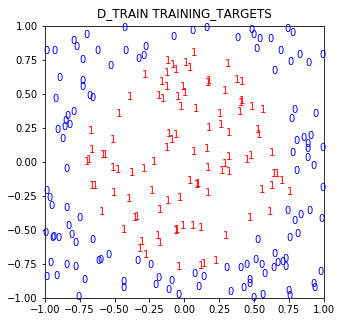

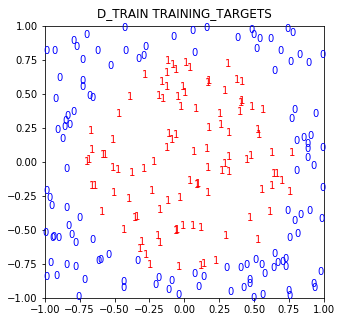

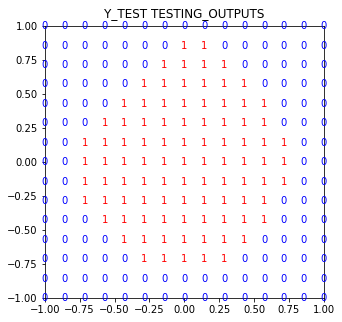

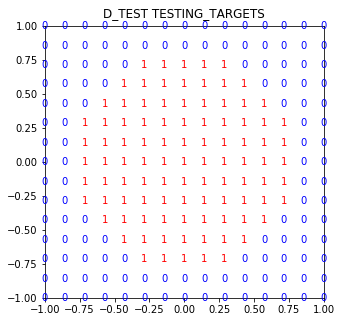

In [0]:
printMatrix( Y_train, X_train, "D_TRAIN TRAINING_TARGETS" )
printMatrix( D_train, X_train, "D_TRAIN TRAINING_TARGETS" ) 
printMatrix(  Y_test,  X_test, "Y_TEST TESTING_OUTPUTS" )
printMatrix(  D_test,  X_test, "D_TEST TESTING_TARGETS" )

# DEBUG

In [0]:
print( h ) 
print( "\nZ",z )
print( "\nO",o ) 
print( "\nY",y )
print( "\nD",d )

print( "\ndelta", delta )
print( "\nE",E )

print( V )
print( "\n",W )

[-21.42640824  -9.25610392  14.60099492   3.20145268  -9.76982214
   5.19932251  -6.65757635   6.39139938]

Z [4.95027282e-10 9.55176569e-05 9.99999544e-01 9.60888908e-01
 5.71472498e-05 9.94510003e-01 1.28260799e-03 9.98326895e-01]

O [-3.55768052]

Y [0.02771486]

D [0.]

delta [-0.00064033]

E [-0.02563543]
[[ -7.35698756   7.56360713  -6.50581355]
 [ -8.14938759   9.02000761   7.91329128]
 [ -0.37337722  -4.25784143  10.71653072]
 [ -9.50260112  -5.7799016    6.9241522 ]
 [ -3.35002228  -0.62976107  -7.04956092]
 [ -3.31626229   1.57194271  10.08752751]
 [ -0.35773623  -4.27394472 -10.57378483]
 [  7.47704977   7.93715805   6.85150766]]

 [[-14.85328158  13.21032356 -15.35519613  13.74964868  -8.89343672
  -15.01388987   5.73756837  13.53161457]]
